# Leveraging Machine Learning with Keras

We have so far implemented our Machine Learning algorithms using vanilla python+numpy for basically everything, from forward to back-propagation and optimization loops.

Although implementing Logistic Regression and even a simple fully-connected neural network was not that hard, it certainly wasn't easy either - and the large number of steps involved increases the likelihood of bugs.

**If we want to go further in our journey through the universe of Machine Learning, we need more powerful tools.**
One such tool is [**Keras**](https://keras.io).
Keras is a library with a python interface that provides several utilities for *Deep Learning* practitioners.

In this tutorial, we attack the problem of multiclass classification over [**Fashion MNIST**](https://github.com/zalandoresearch/fashion-mnist) using Keras as our powerhouse.

In [3]:
#python utilities
import itertools as it
from collections import Counter
import os
import requests
import gzip

#numerical stuff
import numpy as np

#plotting utilities
from matplotlib import pyplot as plt
from matplotlib import style
from matplotlib import colors as mpl_colors
plt.rcParams['figure.figsize'] = [12, 8]
style.use('ggplot')

## Exploring the Fashion MNIST dataset

[**Fashion MNIST**](https://github.com/zalandoresearch/fashion-mnist) is a dataset composed of 70000 images of 10 different types of clothing accessories.
Images are grayscale and fixed at a size of 28x28 pixels.
The dataset is split into 60k training images and 10k test images.
We now explore the dataset.

In [4]:
#Fashion MNIST constants
#image dimensions info
IMG_WIDTH = 28
IMG_HEIGHT = 28
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH)

#classes info
N_CLASSES = 10
CLASS_NAMES = {
    0: 't-shirt/top',
    1: 'trouser',
    2: 'pullover',
    3: 'dress',
    4: 'coat',
    5: 'sandal',
    6: 'shirt',
    7: 'sneaker',
    8: 'bag',
    9: 'ankle boot',
}

In [5]:
def download(url, dst_path):
    '''Downloads a file from given url to destination path.'''
    resp = requests.get(url)
    with open(dst_path, 'wb') as f:
        f.write(resp.content)
        
        
def download_data_if_needed():
    urls = [
        'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz',
        'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz',
        'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz',
        'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz',
    ]
    for url in urls:
        local_path = f'data/{os.path.basename(url)}'
        if not os.path.isfile(local_path):
            os.makedirs('data', exist_ok=True)
            print(f'downloading file from {url} to {local_path}')
            download(url, local_path)
    

def load_data(kind='train'):
    '''
    Loads dataset as two matrices:
    - xs: a (N, 28*28) matrix with flattened images
    - ys: a (N, 10) matrix with one-hot-encoded classes
    '''
    assert kind in {'train', 'test'}
    prefix = 'train' if kind == 'train' else 't10k'
    download_data_if_needed()
    
    xs_path = f'data/{prefix}-images-idx3-ubyte.gz'
    with gzip.open(xs_path, 'rb') as f:
        xs = np.frombuffer(f.read(), dtype='uint8', offset=16)
        xs = xs.reshape((xs.size//(IMG_WIDTH*IMG_HEIGHT), IMG_WIDTH*IMG_HEIGHT)) 
        xs = xs.astype('float32')
        
    ys_path = f'data/{prefix}-labels-idx1-ubyte.gz'
    with gzip.open(ys_path, 'rb') as f:
        ys_classes = np.frombuffer(f.read(), dtype='uint8', offset=8)
        ys = np.zeros(shape=(ys_classes.shape[0], N_CLASSES), dtype='float32')
        ys[np.arange(ys_classes.shape[0]), ys_classes] = 1
        
    return xs, ys

Let's load the train and test splits:

In [6]:
xs, ys = load_data('train')
print('TRAIN SET:')
print(f'xs shape: {xs.shape} | xs dtype: {xs.dtype}')
print(f'ys shape: {ys.shape} | ys dtype: {ys.dtype}')

xs_test, ys_test = load_data('test')
print('TEST SET:')
print(f'xs shape: {xs_test.shape} | xs dtype: {xs_test.dtype}')
print(f'ys shape: {ys_test.shape} | ys dtype: {ys_test.dtype}')

TRAIN SET:
xs shape: (60000, 784) | xs dtype: float32
ys shape: (60000, 10) | ys dtype: float32
TEST SET:
xs shape: (10000, 784) | xs dtype: float32
ys shape: (10000, 10) | ys dtype: float32


It's always good to check how many examples for each class we have:

In [7]:
def count_classes(ys):    
    hist = Counter()
    for y in np.argmax(ys, axis=1).flatten():
        hist[y] += 1
    n_total = sum(hist.values())

    print('classes count:')
    for clase, count in hist.items():
        print(f'{clase} ({CLASS_NAMES[clase]}): {count} ({100*count/n_total:.2f}%)')

In [8]:
count_classes(ys)

classes count:
9 (ankle boot): 6000 (10.00%)
0 (t-shirt/top): 6000 (10.00%)
3 (dress): 6000 (10.00%)
2 (pullover): 6000 (10.00%)
7 (sneaker): 6000 (10.00%)
5 (sandal): 6000 (10.00%)
1 (trouser): 6000 (10.00%)
6 (shirt): 6000 (10.00%)
4 (coat): 6000 (10.00%)
8 (bag): 6000 (10.00%)


The classes are evenly balanced - that's good news! Let's now visualize some images by displaying 5 random examples per class.

In [9]:
def get_image(xs, index):
    return xs[index].reshape(IMG_SHAPE)


def visualize_random_images(xs, ys, n_examples_per_class=5):
    fig = plt.figure(figsize=(IMG_WIDTH, IMG_HEIGHT))
    for i in range(N_CLASSES):
        indexes = np.random.choice(np.where(ys[:, i] == 1)[0], n_examples_per_class)
        for j, index in enumerate(indexes):
            fig.add_subplot(N_CLASSES, n_examples_per_class,
                i*n_examples_per_class + j + 1)
            plt.imshow(get_image(xs, index))
            plt.title(f'idx #{index} ({CLASS_NAMES[i]})')
            plt.axis(False)
    plt.show()

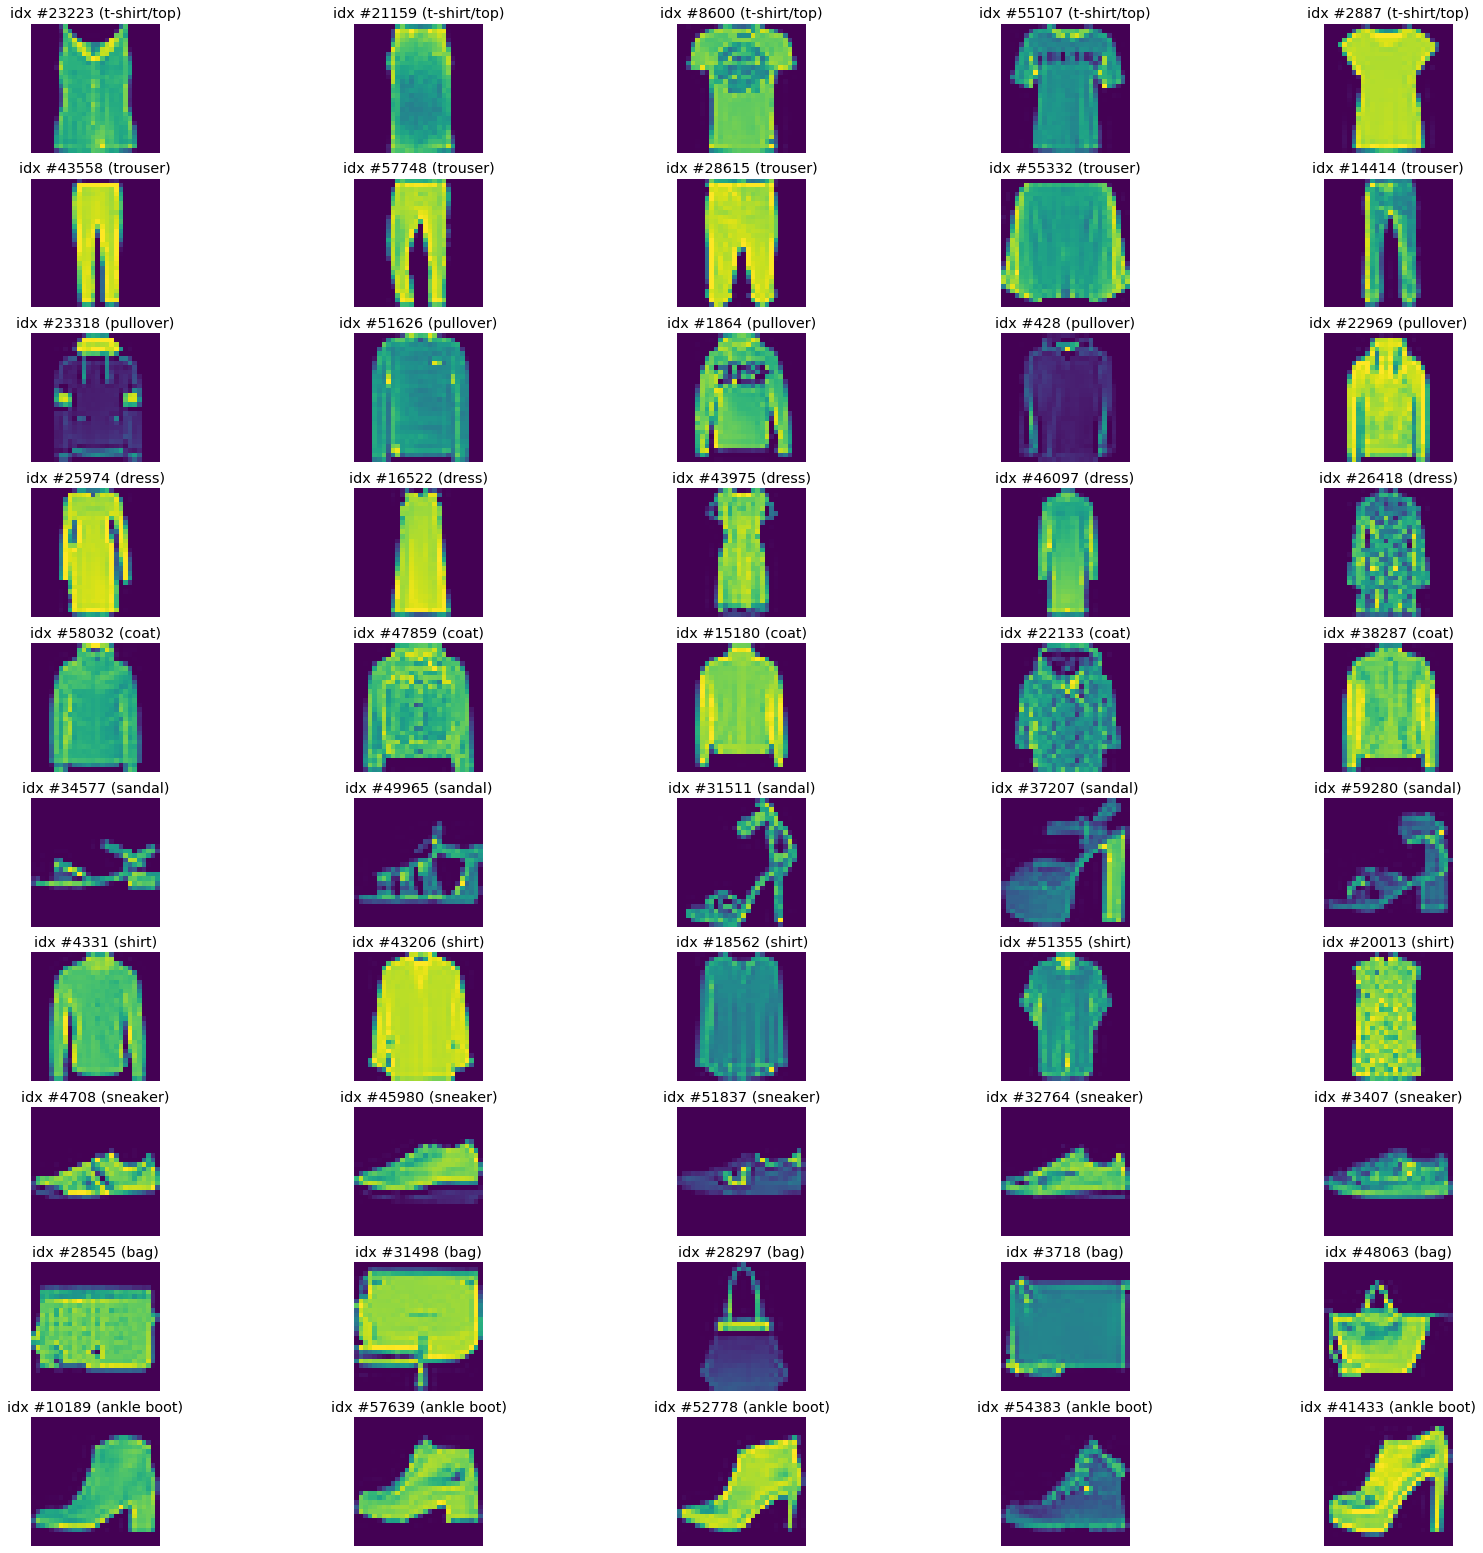

In [10]:
visualize_random_images(xs, ys)

As always, let's normalize our dataset before we proceed.

In [11]:
mean, std = xs.mean(), xs.std()
xs = (xs - mean)/std
xs_test = (xs_test - mean)/std

## Using Keras

[**Keras**](https://keras.io) is a powerful library that provides a lot of Deep Learning related stuff, such as:
- Building blocks for complex architectures
- Optimizers
- Loss functions
- Model evaluation tools
- Automatic differentiation
- Training utilities

And more! You can access this multitude of fast and reliable implementations through a high-level, simple and uniform interface.
Keras abstracts away a lot of the noisy details which allows for fast experimentation and more power overall. The library acts as a "frontend" for lower-level libraries such as [**Tensorflow**](https://www.tensorflow.org/).
However, you can also achieve a high level of customization if you know what you're doing.

The power of Keras is more easily demonstrable via code, so let's do it!

In [13]:
#model creation/loading API
from keras import Model
from keras.models import load_model

#layers to be added to our models
from keras.layers import Dense, Input, Add, Dropout, LeakyReLU

#regularizers
from keras.regularizers import l2

#optimizers
from keras.optimizers import Adam

#callbacks to be used during training
from keras.callbacks import EarlyStopping, ModelCheckpoint

### Implementing Logistic Regression with Keras

Let's build a Logistic Regression model with Keras.

As you may recall, this is logistic regression:
$$y_{pred} = h(x) = sigmoid(Wx + b)$$
$$sigmoid(z) = \frac{1}{1 + e^{-z}}$$

All we need to implement this in Keras is 4 lines:

In [14]:
def get_logistic_regression_model(optimizer='adam'):
    '''Multinomial logistic regression.'''
    
    #input layer, must accept as many inputs as the number of pixels we have
    inp = Input(shape=(IMG_HEIGHT*IMG_WIDTH, ))
    
    #Dense(...)(inp) performs activation over an affine transform W*inp + b
    #while also applying L2 regularization to the weights
    output = Dense(N_CLASSES, activation='softmax', kernel_regularizer=l2(0.001))(inp)
    
    #creating a Model instance by specifying inputs and outputs
    model = Model(inputs=inp, outputs=output)
    #specifying loss/optimizer/metrics for model
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

There's a lot going on under the hood so let's analyze the two main aspects of the code above.

First of all, in the two first lines we're using the [**Functional API**](https://keras.io/getting-started/functional-api-guide/) - which is a concise and flexible method to define simple and complex models.
The main idea is that you add consecutive *layers* on top of another until you get the model you want.
In our case, we first created an `Input` layer, which describes the format of your input. We specify the shape of the input, which is the number of pixels in our 28x28 flattened images.
The next layer to be used is the `Dense` layer. This applies an affine transform to the previous layer, followed by an optional activation (we used softmax).

The last three lines uses the [**Model class API**](https://keras.io/models/model/). After you're done with your architecture (by using layers), you can create a `Model` instance by specifying the inputs and the outputs of the model and then the loss/optimizer/metrics (see: [losses](https://keras.io/losses/), [optimizers](https://keras.io/optimizers/), [metrics](https://keras.io/metrics/)) to be used by the model when training. `Model` instances offer a variety of very useful methods, such as `fit` (equivalent to train), `predict`, `evaluate` as well as visualization/serialization utilities.

Let's now create a `Model` instance of the logistic regression we created and visualize the architecture.

In [15]:
logreg = get_logistic_regression_model(optimizer=Adam(lr=3e-4))
#summary() provides a short description of the main aspects of the architecture
logreg.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


### Training a Model instance

Every `Model` instance can be trained on some data via the [`fit`](https://keras.io/models/model/#fit) method.
This means you don't need to implement either gradient descent or the derivatives (thanks to the automatic differentiation magic) of your model.
No more manual/bug-prone calculations!

There are several arguments that can be used in the `fit` method - I recommend you check it out.
An insteresting concept is that of [**callbacks**](https://keras.io/callbacks/): these are custom routines you can tell Keras to execute (usually) at the end of each training epoch. They are very useful for achieving model checkpointing, early stopping and other stuff.

Below we wrap some Keras training magic into a single method.

In [16]:
def train(model, xs, ys,
          n_epochs=64, batch_size=1024,
          validation_frac=0.2, patience=3,
          **kwargs):
    '''Wrapper for model training method.'''
    
    callbacks = [
        #at the end of each epoch, if the validation loss is the best
        #so far, saves model to data/best_model.h5
        ModelCheckpoint(
            monitor='val_loss',
            filepath='data/best_model.h5',
            save_best_only=True,
        ),
        #if the validation loss does not improve by at least 0.003
        #for a certain number of consecutive epochs, stop training
        EarlyStopping(
            monitor='val_loss',
            min_delta=0.003,
            patience=patience,
        )
    ]

    #the fit method returns the losses/metric achieved at every epoch
    history = model.fit(
        x=xs, y=ys,
        epochs=n_epochs,
        batch_size=batch_size,
        validation_split=validation_frac,
        callbacks=callbacks,
        **kwargs
    ).history
    
    #recovering best model achieved
    if os.path.exists('data/best_model.h5'):
        model = load_model('data/best_model.h5')
        
    return model, history

Let's now train our model!

In [17]:
logreg, history = train(logreg, xs, ys)


Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 0s 8us/step - loss: 1.7273 - accuracy: 0.3961 - val_loss: 1.0843 - val_accuracy: 0.6368
Epoch 2/64
48000/48000 [==============================] - 0s 6us/step - loss: 0.9393 - accuracy: 0.6852 - val_loss: 0.8246 - val_accuracy: 0.7283
Epoch 3/64
48000/48000 [==============================] - 0s 6us/step - loss: 0.7754 - accuracy: 0.7431 - val_loss: 0.7242 - val_accuracy: 0.7626
Epoch 4/64
48000/48000 [==============================] - 0s 6us/step - loss: 0.6961 - accuracy: 0.7702 - val_loss: 0.6664 - val_accuracy: 0.7817
Epoch 5/64
48000/48000 [==============================] - 0s 6us/step - loss: 0.6469 - accuracy: 0.7873 - val_loss: 0.6290 - val_accuracy: 0.7904
Epoch 6/64
48000/48000 [==============================] - 0s 6us/step - loss: 0.6139 - accuracy: 0.7987 - val_loss: 0.6021 - val_accuracy: 0.8006
Epoch 7/64
48000/48000 [==============================] - 0s 6us/step - l

We can use the `history` returned from the `fit` method to visualize the loss progression over training:

In [18]:
def get_colors():
    colors = [
        '#348ABD',
        '#E24A33',
        '#A60628',
        '#467821',
        '#CF4457',
        '#7A68A6',
        '#188487',
    ]
    init_colors = set(colors)
    other_colors = sorted(mpl_colors.cnames.keys())
    colors.extend(c for c in other_colors if c not in init_colors)
    return colors


def _plot_train_history(hist):
    keys = sorted(hist.keys())
    for k, c in zip(keys, get_colors()):
        plt.plot(hist[k], color=c)
    plt.legend(keys, loc='upper left')
    plt.xlabel('epoch')
    plt.ylabel('metric')
    plt.title('train metrics')
    plt.show()
    

def plot_train_history(hist):
    _plot_train_history({'loss': hist['loss'], 'val_loss': hist['val_loss']})
    #_plot_train_history({'accuracy': hist['accuracy'], 'val_accuracy': hist['val_accuracy']})

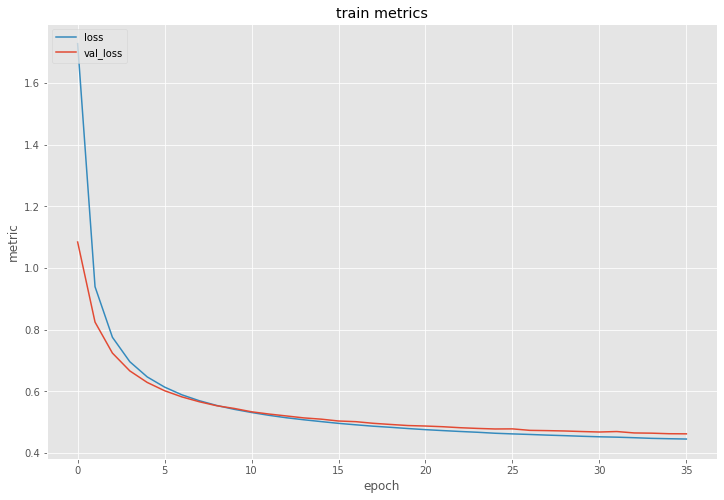

In [19]:
plot_train_history(history)

Every `Model` instance has an `evaluate` method which can be used to quickly access the model performance. In our case, it returns the loss and the accuracy of the model:

In [20]:
logreg.evaluate(xs_test, ys_test)

10000/10000 [==============================] - 0s 21us/step


[0.48555366582870485, 0.8375999927520752]

Let's also implement some visualization utilities for a more detailed evaluation of our model. It will be useful in the future to compare our Logistic Regression with other architectures.

In [21]:
def get_confusion_matrix(ys_true, ys_pred):
    ys_true = np.argmax(ys_true, axis=1)
    ys_pred = np.argmax(ys_pred, axis=1)
    mtx = np.zeros(shape=2*(N_CLASSES, )).astype('uint64')
    for clase in range(N_CLASSES):
        mtx[clase, :] = np.histogram(ys_pred[np.where(ys_true == clase)],
            bins=N_CLASSES, range=(0, N_CLASSES))[0]
    return mtx


def plot_confusion_matrix(mtx, title='Confusion Matrix'):
    fig, ax = plt.subplots(1)

    #setting bounding box
    ax.spines['bottom'].set_color('black')
    ax.spines['top'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_color('black')

    plt.title(title)
    #plt.colorbar()

    #setting ticks
    classes = list(CLASS_NAMES.values())
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    #number of ocurrences
    thr = mtx.max()/2
    for i, j in it.product(range(mtx.shape[0]), range(mtx.shape[1])):
        plt.text(j, i, mtx[i, j],
            horizontalalignment='center',
            color='white' if mtx[i, j] > thr else 'black')

    plt.grid(False)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

    #displaying matrix
    plt.imshow(mtx, interpolation='nearest', cmap='Blues')
    plt.show()

    return fig, ax


def harmonic_mean_of_positive_values(values, eps=1e-18):
    return len(values)/sum(1/max(v, eps) for v in values)


def get_metrics(conf_mtx):
    metrics = []
    mtx_sum = conf_mtx.sum()
    for i in range(conf_mtx.shape[0]):
        col_sum = conf_mtx[:, i].sum()
        row_sum = conf_mtx[i].sum()
        
        tp = conf_mtx[i][i]
        fp = col_sum - tp
        tn = mtx_sum - (row_sum + col_sum - tp)
        fn = row_sum - tp
        metrics.append((tp, fp, tn, fn))
    return metrics


def get_accuracy(conf_mtx):
    return conf_mtx.diagonal().sum()/conf_mtx.sum()


def get_f1_score(tp, fp, tn, fn, eps=1e-18):
    precision = tp/max(tp + fp, eps)
    recall = tp/max(tp + fn, eps)
    f1 = 2*precision*recall/(precision + recall)
    return f1
 

def get_f1_scores(conf_mtx):
    metrics = get_metrics(conf_mtx)
    return [get_f1_score(*m) for m in metrics]


def evaluate(model, xs, ys_true):
    ys_pred = model.predict(xs)
    
    conf_mtx = get_confusion_matrix(ys_true, ys_pred)
    plot_confusion_matrix(conf_mtx)
    
    print(f'overall accuracy: {get_accuracy(conf_mtx):.3f}')
    
    f1s = get_f1_scores(conf_mtx)
    print()
    print('f1 scores:')
    for i in range(conf_mtx.shape[0]):
        print(f'class {i} ({CLASS_NAMES[i]}): {f1s[i]:.3f}')
    print()
    print(f'combined f1-score: {harmonic_mean_of_positive_values(f1s):.3f}')

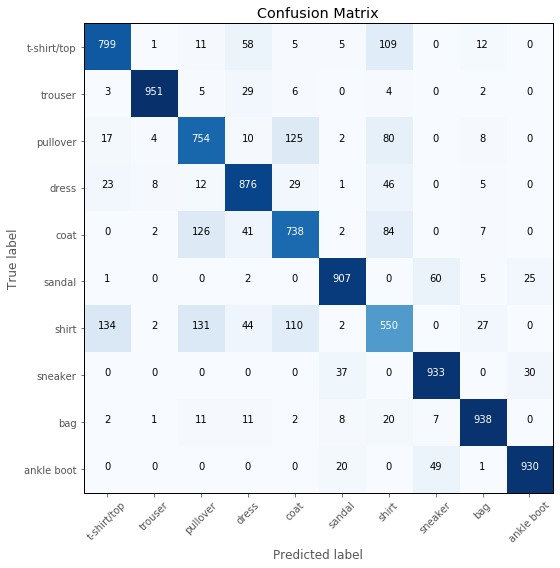

overall accuracy: 0.838

f1 scores:
class 0 (t-shirt/top): 0.807
class 1 (trouser): 0.966
class 2 (pullover): 0.736
class 3 (dress): 0.846
class 4 (coat): 0.733
class 5 (sandal): 0.914
class 6 (shirt): 0.581
class 7 (sneaker): 0.911
class 8 (bag): 0.936
class 9 (ankle boot): 0.937

combined f1-score: 0.818


In [22]:
evaluate(logreg, xs_test, ys_test)

We can see our Logistic Regression model did pretty well overall.
Intuitively, the model mistakes pullovers for coats (and vice versa) as well as shirt for t-shirt and sandal for sneaker/ankle boot

We now try to improve our performance with complexity by creating a Multi Layer Perceptron (or neural network).

In [23]:
def get_neural_network_model(n_hidden_units, optimizer='adam'):
    #input
    inp = Input(shape=(IMG_HEIGHT*IMG_WIDTH, ))
    #hidden layer
    hidden = Dense(n_hidden_units, activation='relu', kernel_regularizer=l2(0.001))(inp)
    #output (aka logistic regression to the output of the hidden layer)
    output = Dense(N_CLASSES, activation='softmax', kernel_regularizer=l2(0.001))(hidden)
    
    model = Model(inputs=inp, outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

Note that it was almost as simple as building logistic regression - we just needed one extra line.
We can see the neural networks contains way more parameters than a simple logistic regression:

In [24]:
nn = get_neural_network_model(n_hidden_units=64, optimizer=Adam(lr=1e-4))
nn.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                50240     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________


Let's now train our neural network. Note it uses *exactly* the same methods as our Logistic Regression! Keras is doing a good job abstracting the details and doing the heavy and boring work for us.

In [25]:
nn, history = train(nn, xs, ys)

Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 0s 9us/step - loss: 2.0809 - accuracy: 0.3476 - val_loss: 1.4308 - val_accuracy: 0.5718
Epoch 2/64
48000/48000 [==============================] - 0s 7us/step - loss: 1.2205 - accuracy: 0.6371 - val_loss: 1.0592 - val_accuracy: 0.6853
Epoch 3/64
48000/48000 [==============================] - 0s 8us/step - loss: 0.9789 - accuracy: 0.7143 - val_loss: 0.9058 - val_accuracy: 0.7318
Epoch 4/64
48000/48000 [==============================] - 0s 7us/step - loss: 0.8603 - accuracy: 0.7520 - val_loss: 0.8198 - val_accuracy: 0.7598
Epoch 5/64
48000/48000 [==============================] - 0s 7us/step - loss: 0.7892 - accuracy: 0.7772 - val_loss: 0.7659 - val_accuracy: 0.7782
Epoch 6/64
48000/48000 [==============================] - 0s 7us/step - loss: 0.7411 - accuracy: 0.7924 - val_loss: 0.7251 - val_accuracy: 0.7936
Epoch 7/64
48000/48000 [==============================] - 0s 7us/step - lo

48000/48000 [==============================] - 0s 7us/step - loss: 0.4485 - accuracy: 0.8838 - val_loss: 0.4851 - val_accuracy: 0.8679
Epoch 57/64
48000/48000 [==============================] - 0s 7us/step - loss: 0.4470 - accuracy: 0.8841 - val_loss: 0.4821 - val_accuracy: 0.8689
Epoch 58/64
48000/48000 [==============================] - 0s 7us/step - loss: 0.4451 - accuracy: 0.8849 - val_loss: 0.4802 - val_accuracy: 0.8695
Epoch 59/64
48000/48000 [==============================] - 0s 7us/step - loss: 0.4429 - accuracy: 0.8857 - val_loss: 0.4791 - val_accuracy: 0.8685
Epoch 60/64
48000/48000 [==============================] - 0s 7us/step - loss: 0.4415 - accuracy: 0.8855 - val_loss: 0.4776 - val_accuracy: 0.8698
Epoch 61/64
48000/48000 [==============================] - 0s 7us/step - loss: 0.4394 - accuracy: 0.8863 - val_loss: 0.4768 - val_accuracy: 0.8699
Epoch 62/64
48000/48000 [==============================] - 0s 7us/step - loss: 0.4380 - accuracy: 0.8864 - val_loss: 0.4761 - val_

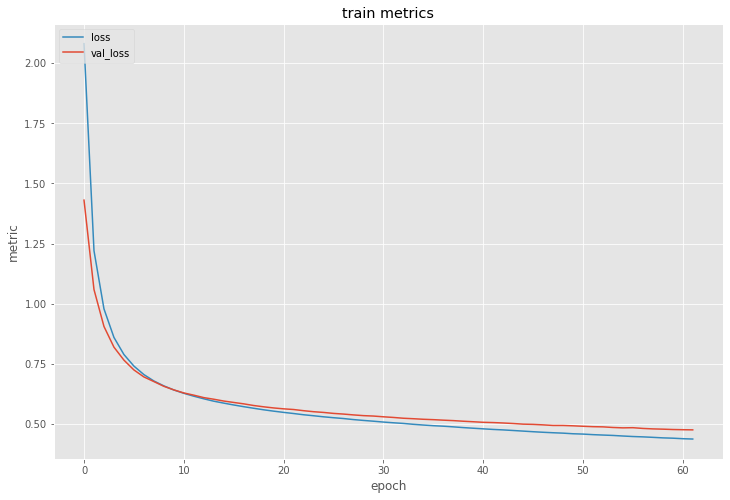

In [26]:
plot_train_history(history)

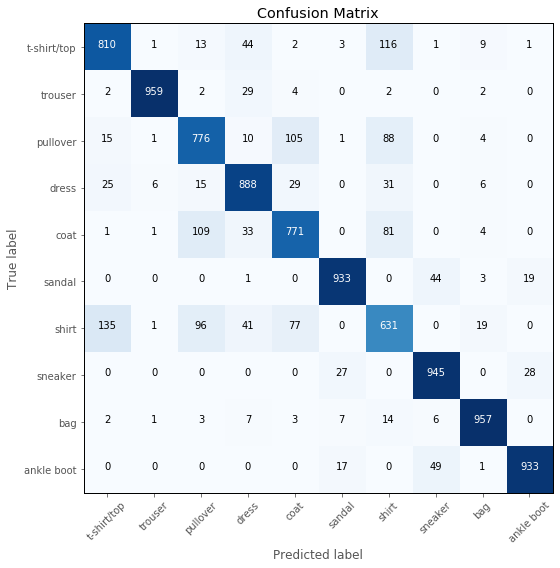

overall accuracy: 0.860

f1 scores:
class 0 (t-shirt/top): 0.814
class 1 (trouser): 0.974
class 2 (pullover): 0.771
class 3 (dress): 0.865
class 4 (coat): 0.774
class 5 (sandal): 0.939
class 6 (shirt): 0.643
class 7 (sneaker): 0.924
class 8 (bag): 0.955
class 9 (ankle boot): 0.942

combined f1-score: 0.847


In [27]:
evaluate(nn, xs_test, ys_test)

As expected, the neural network performed better than our Logistic Regression.

Let's now get more exotic and implement a neural network with 3 hidden layers and a variety of tricks, such as [Leaky ReLU](https://keras.io/layers/advanced-activations/), [Dropout](https://medium.com/@amarbudhiraja/https-medium-com-amarbudhiraja-learning-less-to-learn-better-dropout-in-deep-machine-learning-74334da4bfc5) and [Skip-connections](https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec). We can see it's very easy to do all these gimmicks with Keras - the library already provides everything we need!

In [28]:
def get_fancy_neural_network_model(n_hidden_units, optimizer='adam'):
    inp = Input(shape=(IMG_HEIGHT*IMG_WIDTH, ))
    
    #hidden layer 1: leaky ReLU and dropout
    hidden1 = Dense(n_hidden_units, activation='tanh')(inp)
    hidden1 = LeakyReLU(alpha=0.1)(hidden1)
    hidden1 = Dropout(rate=0.3)(hidden1)
    
    #hidden layer 2: leaky ReLU and dropout
    hidden2 = Dense(n_hidden_units)(hidden1)
    hidden2 = LeakyReLU(alpha=0.1)(hidden2)
    hidden2 = Dropout(rate=0.3)(hidden2)
    
    #hidden layer 3: leaky ReLU, skip-connection and dropout
    hidden3 = Dense(n_hidden_units)(hidden2)
    hidden3 = LeakyReLU(alpha=0.1)(hidden3)
    hidden3 = Add()([hidden1, hidden3])
    hidden3 = Dropout(rate=0.3)(hidden3)
    
    output = Dense(N_CLASSES, activation='softmax')(hidden3)
    
    model = Model(inputs=inp, outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

The price we pay for this network is the even greater number of parameters.

In [29]:
fancy_nn = get_fancy_neural_network_model(n_hidden_units=256, optimizer=Adam(lr=1e-4))
fancy_nn.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 256)          200960      input_3[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 256)          0           dense_4[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 256)          0           leaky_re_lu_1[0][0]              
____________________________________________________________________________________________

In [30]:
fancy_nn, history = train(fancy_nn, xs, ys)

Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 2s 33us/step - loss: 1.6493 - accuracy: 0.4291 - val_loss: 0.8888 - val_accuracy: 0.7172
Epoch 2/64
48000/48000 [==============================] - 2s 32us/step - loss: 0.9430 - accuracy: 0.6743 - val_loss: 0.6767 - val_accuracy: 0.7705
Epoch 3/64
48000/48000 [==============================] - 2s 32us/step - loss: 0.7676 - accuracy: 0.7316 - val_loss: 0.5868 - val_accuracy: 0.7942
Epoch 4/64
48000/48000 [==============================] - 2s 32us/step - loss: 0.6771 - accuracy: 0.7612 - val_loss: 0.5374 - val_accuracy: 0.8065
Epoch 5/64
48000/48000 [==============================] - 1s 28us/step - loss: 0.6226 - accuracy: 0.7808 - val_loss: 0.5038 - val_accuracy: 0.8198
Epoch 6/64
48000/48000 [==============================] - 1s 30us/step - loss: 0.5808 - accuracy: 0.7964 - val_loss: 0.4792 - val_accuracy: 0.8267
Epoch 7/64
48000/48000 [==============================] - 1s 30us/st

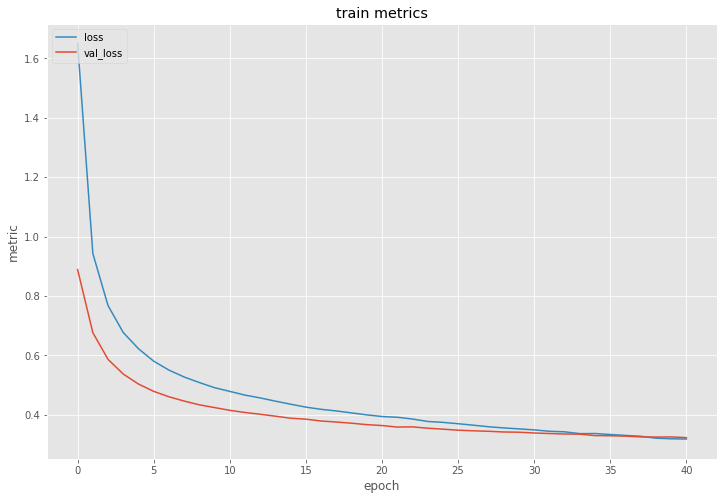

In [31]:
plot_train_history(history)

Let's see how our fancy network performs on the test set:

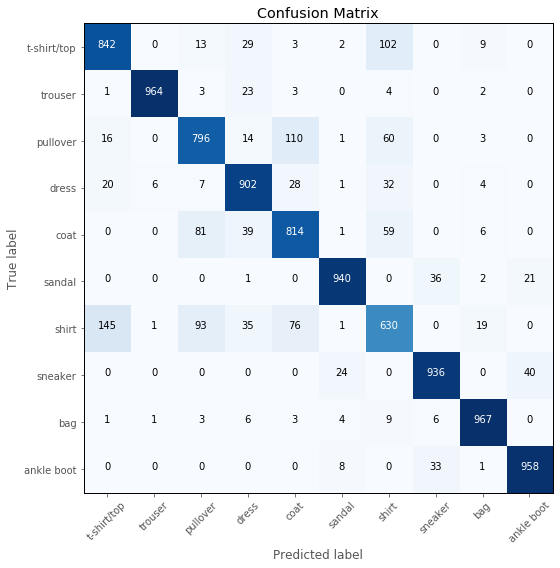

overall accuracy: 0.875

f1 scores:
class 0 (t-shirt/top): 0.832
class 1 (trouser): 0.978
class 2 (pullover): 0.798
class 3 (dress): 0.880
class 4 (coat): 0.799
class 5 (sandal): 0.949
class 6 (shirt): 0.665
class 7 (sneaker): 0.931
class 8 (bag): 0.961
class 9 (ankle boot): 0.949

combined f1-score: 0.863


In [32]:
evaluate(fancy_nn, xs_test, ys_test)

Another (slight) gain in performance!

In this notebook, you were introduced to the power of the Keras. We just scratched the surface; there are many more useful things you can use from the library. It's now up to you to further explore the documentation and have fun putting some code together!